In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/soumik12345/MIRNet
%cd MIRNet

Cloning into 'MIRNet'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 251 (delta 10), reused 8 (delta 8), pack-reused 237
Receiving objects: 100% (251/251), 28.13 MiB | 20.41 MiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/MIRNet


In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 9.2 MB/s 
     |████████████████████████████████| 181 kB 65.9 MB/s 
     |████████████████████████████████| 145 kB 70.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result

import tensorflow as tf
import numpy as np


In [ ]:
inferer = Inferer()
inferer.download_weights('1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)
# inferer.model.summary()

Downloading...
From: https://drive.google.com/uc?id=1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL
To: /content/MIRNet/low_light_weights_best.h5
100%|██████████| 148M/148M [00:00<00:00, 243MB/s]


In [ ]:
def brightness_normaliztion(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #Convert to hsv color system
    h,s,v = cv2.split(hsv) #Divided into each component
    # plt.hist(v.ravel(),256,[0,256]);plt.show()
    result = cv2.equalizeHist(v)
    # plt.hist(result.ravel(),256,[0,256]);plt.show()
    hsv = cv2.merge((h,s,result))
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    # rgb = cv2.detailEnhance(rgb, sigma_s=10, sigma_r=0.15)
    # rgb = cv2.edgePreservingFilter(rgb, flags=1, sigma_s=64, sigma_r=0.2)
    return rgb

In [ ]:
import cv2

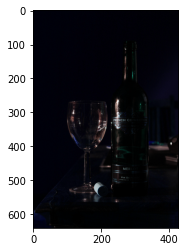

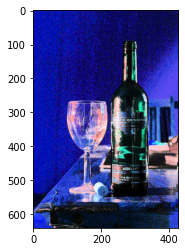

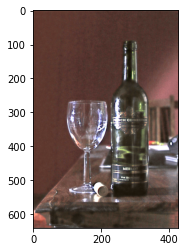

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.imread('/content/drive/MyDrive/bata/Test/Images/2019_01594.jpg'))
plt.show()
plt.imshow(brightness_normaliztion(cv2.imread('/content/drive/MyDrive/bata/Test/Images/2019_01594.jpg')))
plt.show()
original_image, output_image = inferer.infer('/content/drive/MyDrive/bata/Test/Images/2019_01594.jpg')
plt.imshow(output_image)

In [ ]:
def load_data(path_txt,path_img):
  with open(path_txt) as f:
      lines = f.readlines()
  lines = lines[1:]
  x =[]
  y =[]
  l = []
  for i in lines:
    line = i.split(' ')
    y.append(line[2][0])
    l.append(line[1])
    if(line[1]==6):
      x.append(cv2.imread(path_img+line[0]))
    elif(line[1]==1 or line[1]==5): 
      original_image, output_image = inferer.infer(path_img+line[0])
      x.append(np.asarray(output_image))
    else:
      x.append(brightness_normaliztion(cv2.resize(cv2.imread(path_img+line[0]),(224,224))))
  x = np.array(x)
  y = np.array(y)
  l = np.array(l)
  return x,y,l

In [ ]:
path_txt = '/content/drive/MyDrive/bata/TrainImageLabels.txt'
path_img = '/content/drive/MyDrive/bata/Train/Images/'
x_train , y_train,l_train = load_data(path_txt,path_img)

In [ ]:
x_train.shape,y_train.shape,l_train.shape

((3000, 224, 224, 3), (3000,), (3000,))

In [ ]:
path_txt = '/content/drive/MyDrive/bata/TestImageLabels.txt'
path_img = '/content/drive/MyDrive/bata/Test/Images/'
x_test , y_test,l_test = load_data(path_txt,path_img)

In [ ]:
x_test.shape,y_test.shape,l_test.shape

((1800, 224, 224, 3), (1800,), (1800,))

In [ ]:
y_test = np.expand_dims(y_test,axis=1)
y_train = np.expand_dims(y_train,axis=1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
y_train.shape,y_test.shape

((3000, 2), (1800, 2))

In [ ]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

from keras.backend import image_data_format
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.utils import get_file
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf


In [ ]:
model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="sigmoid"
)

In [ ]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)


model = Model(inputs=model.input, outputs=predictions)

In [ ]:
import time
t0 = time.time()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs

trained = model.fit(x_train, y_train,validation_data = (x_test, y_test),batch_size = 16, epochs=12)

188/188 [==============================] - 95s 412ms/step - loss: 0.1185 - accuracy: 0.9583 - val_loss: 0.5622 - val_accuracy: 0.8439


In [ ]:
t1 = time.time()
total = t1-t0
total/60

19.64821622769038

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_841 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_841[0][0]']             
 Normalization)                 )                                                           

In [ ]:
model.save('model.h5')

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/model.h5')